# Find Bounding Boxes with OpenCV

I am trying to use some method of automatically finding products based on the downloaded images, within the video files, to extract bounding boxes to fine-tune YOLO models.

So far the results are bad

In [19]:
import os
import pandas as pd
from PIL import Image
import cv2
import numpy as np

current_dir = os.path.dirname(os.path.abspath("__file__"))

In [23]:
# Get video directory
video_file = os.path.join(current_dir, "videos/fruit_loops.mov")

if os.path.exists(video_file):
    print("Video file found.")

Video file found.


In [8]:
# Get product info and images
product_df = pd.read_csv(os.path.join(current_dir, "product_info.csv"))
product_df.head()

,index,product_brand,product_title,current_price,min_quantity,regular_price,sale_price,was_price,non_members_price,product_image
0,0,General Mills,"Honey Nut Cheerios Breakfast Cereal, Whole Grains",3.00,1,NaN,3.0,4.50,NaN,https://digital.loblaws.ca/PCX/21104047_EA/en/...
1,1,Post,Shreddies Original Cereals,5.49,1,5.49,NaN,NaN,NaN,https://digital.loblaws.ca/PCX/21427214_EA/en/...
2,2,Kelloggs,Rice Krispies Cereal,4.50,2,NaN,4.5,NaN,5.79,https://digital.loblaws.ca/PCX/21450814_EA/en/...
3,3,General Mills,Cheerios Whole Grain Breakfast Cereal Limited ...,3.00,1,NaN,3.0,4.50,NaN,https://digital.loblaws.ca/PCX/21104173_EA/en/...
4,4,Kelloggs,Rice Krispies Original,6.00,1,NaN,6.0,7.99,NaN,https://digital.loblaws.ca/PCX/21449784_EA/en/...


Loading image from: /Volumes/SSD_1/grocery-store-inventory/JA/product_images/15.png


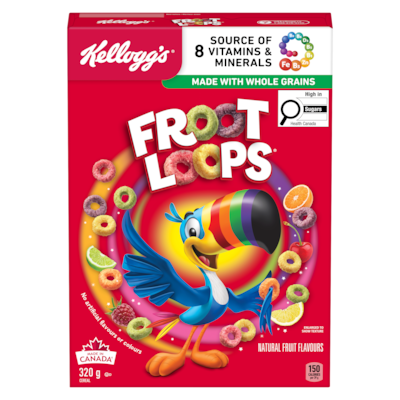

In [14]:
#Get a product, and load the image which is index.png
product = product_df.iloc[15]

product_id = product['index']
image_path = os.path.join(current_dir, "product_images", f"{product_id}.png")
print(f"Loading image from: {image_path}")

#display image in cell output
image = Image.open(image_path)
display(image)

## Try cv2 methods

In [24]:
# Paths to video and target image
output_dir = os.path.join(current_dir, "output_frames")
os.makedirs(output_dir, exist_ok=True)  # Create the output directory if it doesn't exist

# Load the target image
target_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Open the video file
cap = cv2.VideoCapture(video_file)
if not cap.isOpened():
    print(f"Video file not found at {video_file}")
    exit()

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Create a log file to store filenames and confidence scores
log_file = os.path.join(output_dir, "detections_log.csv")
with open(log_file, "w") as log:
    log.write("frame_number,confidence,output_filename\n")

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and descriptors in the target image
keypoints1, descriptors1 = sift.detectAndCompute(target_image, None)

# Create a BFMatcher object for feature matching
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Process each frame
frame_number = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break  # End of video

    frame_number += 1

    # Convert the frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect keypoints and descriptors in the current frame
    keypoints2, descriptors2 = sift.detectAndCompute(gray_frame, None)

    if descriptors2 is not None:
        # Match features between the target image and the current frame
        matches = bf.match(descriptors1, descriptors2)

        # Sort matches by distance (lower distance is better)
        matches = sorted(matches, key=lambda x: x.distance)

        # Draw matches if enough good matches are found
        good_matches = matches[:10]  # Use the top 10 matches
        if len(good_matches) > 5:  # Minimum number of matches to consider a detection
            # Extract the matched keypoints
            src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

            # Find the homography matrix
            matrix, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 3.0)

            if matrix is not None:
                # Get the bounding box of the target image
                h, w = target_image.shape
                points = np.float32([[0, 0], [w, 0], [w, h], [0, h]]).reshape(-1, 1, 2)

                # Transform the points to the current frame
                transformed_points = cv2.perspectiveTransform(points, matrix)

                # Draw the bounding box on the frame
                frame = cv2.polylines(frame, [np.int32(transformed_points)], True, (0, 255, 0), 3)

                # Save the frame with the bounding box
                output_filename = f"frame_{frame_number:04d}.jpg"
                output_path = os.path.join(output_dir, output_filename)
                cv2.imwrite(output_path, frame)

                # Log the detection
                with open(log_file, "a") as log:
                    log.write(f"{frame_number},SIFT,{output_filename}\n")

# Release resources
cap.release()
cv2.destroyAllWindows()

print(f"Processed video with SIFT. Results saved to {output_dir}")

Processed video with SIFT. Results saved to /Volumes/SSD_1/grocery-store-inventory/JA/output_frames


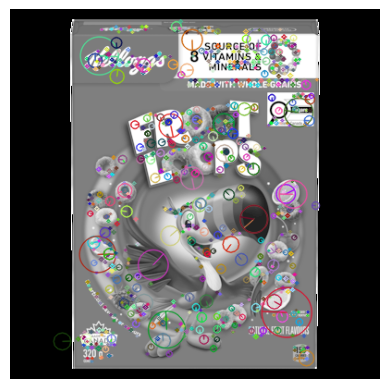

In [26]:
#Overlay the keypoints on the image
keypoint_image = cv2.drawKeypoints(target_image, keypoints1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

#Show in cell output
from matplotlib import pyplot as plt
plt.imshow(keypoint_image, cmap='gray')
plt.axis('off')
plt.show()